# <font color=Brown> Loading the required libraries </font>

In [1]:
## Loading the required libraries and getting started

require(reshape2)
require(ggplot2)
require(zoo)
require(data.table)
require(lubridate)
require(xts)

Loading required package: reshape2

Loading required package: ggplot2

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:reshape2':

    dcast, melt


Loading required package: lubridate


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: xts


Attaching package: 'xts'


The following objects are masked from 'package:data.table':

    first, last




# <font color = brown> Loading Input Data (Libor and Interest rate Swap) into Global Environment </font>

In [2]:
## Loading the input data of Libor rates with 1 month,3 month and 6 month maturity period and Interest Rate Swaps data with maturity period of 1,2,3,4,5,7,10, and 30 years
## LIBOR Data Source: "http://iborate.com/usd-libor/"
## Interest Rate Swaps Data Scource: "https://www.federalreserve.gov/datadownload/Download.aspx?rel=H15&series=84ddab530b2969fa9a146dfe640cb6d2&filetype=csv&label=include&layout=seriescolumn&from=01/01/2000&to=12/31/2020"

setwd("C:/Users/gargn/Documents/Finance_in_R_Jupyter _Notebook/InterestRateModelling_usingPCA")

libor <- fread("LIBOR USD.csv", sep=",")
head(libor,20)
libor[,c(1,5,7,8)][,Date:=dmy(Date)][,yearmonth:=year(Date)*1e2+month(Date)][,c(2:4):=lapply(.SD, mean), .SDcols=c(2:4),by=yearmonth] -> libor
libor[,c(5,2:4)][order(yearmonth)] -> libor
unique(libor) -> libor
libor[yearmonth>=200007 & yearmonth<=201609] -> libor
colnames(libor)[2:4] <- paste0("libor_",c(1,3,6),"m")
as.zoo(libor[,c(2:4)], as.yearmon(as.character(libor$yearmonth), format="%Y%m")) -> libor

swap <- fread("FRB_H15.csv", sep=",")
swap <- swap[6:nrow(swap)]
colnames(swap) <- c("date",paste0("swap_",as.character(c(1:5,7,10,30)),"yr"))
swap[,c(2:9):=lapply(.SD, FUN = function(x){as.double(x)}), .SDcols=c(2:9)]
swap[,date:=as.yearmon(date,format="%Y-%m")]
swap[complete.cases(swap)] -> swap
swap <- as.zoo(swap[,c(2:9)], swap$date)

Date,Week day,ON,1W,1M,2M,3M,6M,12M
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30.12.2016,Fri,0.69211,0.72333,0.77167,0.81944,0.99789,1.31767,1.68567
29.12.2016,Thu,0.68822,0.72333,0.77111,0.81944,0.99789,1.31767,1.68733
28.12.2016,Wed,0.68656,0.71533,0.77000,0.81611,0.99817,1.31767,1.69011
23.12.2016,Fri,0.69378,0.71144,0.76111,0.81444,0.99706,1.31656,1.68956
22.12.2016,Thu,0.68656,0.71144,0.75611,0.81333,0.99706,1.31600,1.68789
21.12.2016,Wed,0.68600,0.70778,0.75500,0.81139,0.99761,1.31600,1.68956
20.12.2016,Tue,0.68378,0.70500,0.74900,0.81056,0.99622,1.32044,1.69067
19.12.2016,Mon,0.68111,0.70306,0.74400,0.81000,0.99428,1.31767,1.69178
16.12.2016,Fri,0.68389,0.70444,0.73900,0.80944,0.99733,1.31989,1.69344


# <font color = brown> Plotting Merged Libor and Interest Rate Swap data (July 2000 - Sep 2016) </font>

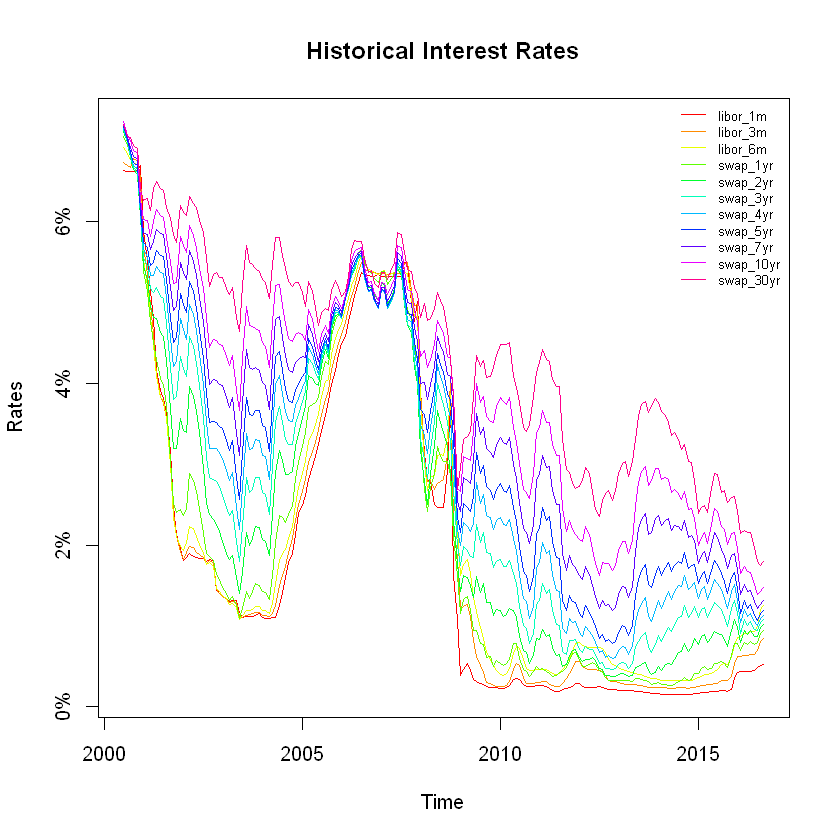

In [3]:
## Merging Libor and Swap Rates and plotting them from July 2000 to September 2016

rates<- merge(libor,swap,all=T)
tsRainbow = rainbow(ncol(rates))
plot(x=rates,col=tsRainbow, main="Historical Interest Rates", ylab="Rates", xlab="Time", plot.type="single", xaxt ="n", yaxt="n")
axis(1)
pts<- pretty(rates)
axis(2, at=pts, labels=paste(pts, "%", sep=""))
legend(x="topright", legend=colnames(rates), lty=1, col=tsRainbow, cex=.64,bty="n")


# <font color = brown> Interpolating Swap Rates for every 0.5 year interval of maturity from 1 year upto 30 years </font>

In [4]:
# This section contains helper functions for interpolating Swap Rates for every 0.5 year period ranging from 1Yr period to 30Yr period.

# This function reads the header of a swap rate table and returns an object with elements col and tenor both of which are 
# vectors. They identify theknown tenors and the column location of them in the swap rate table.

avail_tenors <- function(header) {
  txtStart = regexpr("_",header)
  txtEnd = regexpr("yr",header)
  
  tenors <- as.integer(substr(header,txtStart+1,txtEnd-1))
  result = data.table(col = seq(1,length(header)), tenor = tenors)
  return(result)
}

at <- avail_tenors(colnames(swap))

# Given a year and header of a swap rate table, this function returns a data.table of 2*2, where the second column is the tenor
# column whose first row is the known tenor just below the given year, the second row is the known tenor just above the given 
# year, and the first column contains the corresponding column position of these tenor rates in the swap rate table for every 
# 0.5 year period.

highlow <- function(yr) {
   
  if(yr %in% at$tenor) {
    return (NULL)
  }
  else {
    for(i in 1:nrow(at)) {
      if(at$tenor[i] > yr) return (at[(i-1):i,])
    }
  }
}

highlow(1.5)

# This function takes a year and a swap rate table and linearly interpolates (taken as a weighted average) across the whole time series
# For a maturity period i, let low known tenor be rate br LR and its maturity be L and corresponding high known tenor rate be HR and its
# maturity be H, then the interpolated Swap Rate will be: LR*(H-i) + HR*(i-L).
# For example : for maturity period 8.5yr, calculated rate will be: rate_for_5yr*(10-8.5) + rate_for_10_yr*(8.5-5).

interpolateSwaps <- function(swap,yr) {
  hl <- highlow(yr)
  
  if(is.null(hl)) {
    return (NULL)
  }
  
  else{
    return ((swap[,hl$col[1]]*(hl$tenor[2]-yr) + swap[,hl$col[2]]*(yr-hl$tenor[1]))/(hl$tenor[2] - hl$tenor[1]))
  }
}

interpolateSwaps(swap,1.5)
interpolateSwaps(swap,10)

interpolateSwapsperiods <- function(yrLow,yrHigh,freq,swap) {
  result <- swap
  for (i in seq(from = yrLow, to = yrHigh, by=freq)) {
    if(i %in% at$tenor) {
      
    }
    else {
      result$newcol <- interpolateSwaps(result,i)
      colnames(result)[length(colnames(result))] <- paste0("swap_",i,"yr") 
    }
  }
  return (result)
}

swap <- interpolateSwapsperiods(1,30,0.5,swap)

at <- avail_tenors(colnames(swap))
at <- at[order(tenor)]
swap[,at$col] -> swap

head(swap,20)

col,tenor
<int>,<int>
1,1
2,2


Jul 2000 Aug 2000 Sep 2000 Oct 2000 Nov 2000 Dec 2000 Jan 2001 Feb 2001 
   7.085    6.965    6.795    6.675    6.615    6.120    5.410    5.210 
Mar 2001 Apr 2001 May 2001 Jun 2001 Jul 2001 Aug 2001 Sep 2001 Oct 2001 
   4.860    4.660    4.545    4.345    4.285    4.000    3.370    2.860 
Nov 2001 Dec 2001 Jan 2002 Feb 2002 Mar 2002 Apr 2002 May 2002 Jun 2002 
   2.800    3.000    2.895    2.920    3.420    3.320    3.155    2.920 
Jul 2002 Aug 2002 Sep 2002 Oct 2002 Nov 2002 Dec 2002 Jan 2003 Feb 2003 
   2.545    2.205    2.120    2.065    1.950    1.870    1.760    1.650 
Mar 2003 Apr 2003 May 2003 Jun 2003 Jul 2003 Aug 2003 Sep 2003 Oct 2003 
   1.570    1.615    1.430    1.245    1.435    1.785    1.670    1.750 
Nov 2003 Dec 2003 Jan 2004 Feb 2004 Mar 2004 Apr 2004 May 2004 Jun 2004 
   1.875    1.860    1.745    1.730    1.600    2.005    2.465    2.765 
Jul 2004 Aug 2004 Sep 2004 Oct 2004 Nov 2004 Dec 2004 Jan 2005 Feb 2005 
   2.690    2.575    2.625    2.695    3.020    3.2

NULL

         swap_1yr swap_1.5yr swap_2yr swap_2.5yr swap_3yr swap_3.5yr swap_4yr
Jul 2000     7.05      7.085     7.12      7.130     7.14      7.145     7.15
Aug 2000     6.95      6.965     6.98      6.985     6.99      6.995     7.00
Sep 2000     6.80      6.795     6.79      6.800     6.81      6.820     6.83
Oct 2000     6.70      6.675     6.65      6.660     6.67      6.685     6.70
Nov 2000     6.65      6.615     6.58      6.595     6.61      6.635     6.66
Dec 2000     6.18      6.120     6.06      6.065     6.07      6.090     6.11
Jan 2001     5.38      5.410     5.44      5.500     5.56      5.610     5.66
Feb 2001     5.14      5.210     5.28      5.360     5.44      5.505     5.57
Mar 2001     4.77      4.860     4.95      5.060     5.17      5.250     5.33
Apr 2001     4.51      4.660     4.81      4.965     5.12      5.225     5.33
May 2001     4.29      4.545     4.80      4.995     5.19      5.320     5.45
Jun 2001     4.06      4.345     4.63      4.855     5.08      5

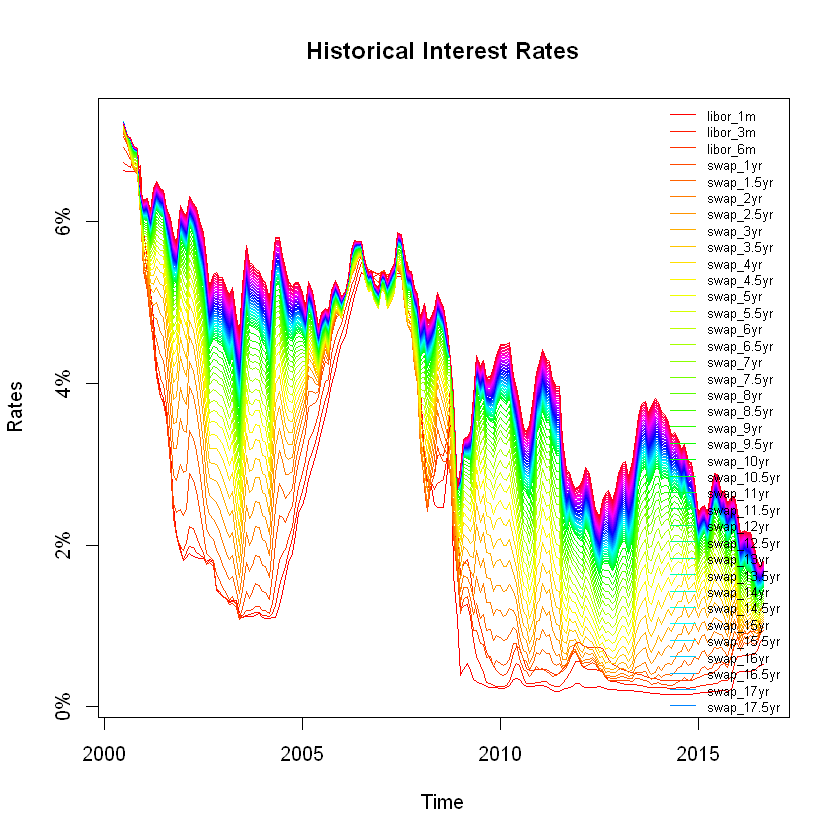

In [5]:
# Plotting Interpolated Swap Rates for continuous maturities ranging from 1yr to 30 yr with every 1/2 yr interval

rates<- merge(libor, swap, all=FALSE)
tsRainbow <- rainbow(ncol(rates))
plot(x=rates,col=tsRainbow, main="Historical Interest Rates", ylab="Rates", xlab="Time", plot.type="single", xaxt ="n", yaxt="n")
axis(1)
pts<- pretty(rates)
axis(2, at=pts, labels=paste(pts, "%", sep=""))
legend(x="topright", legend=colnames(rates), lty=1, col=tsRainbow, cex=.64,bty="n")


# <font color=brown> Calculating Spot Rates using BootStrapping </font>

In [6]:
# Calculating Spot rates using commonly used bootstrapping technique

bootstrap<-function(freq,libor, swap){
  at <- avail_tenors(colnames(swap))
  max <- at$tenor[NCOL(swap)]
  result <- libor[,match("libor_6m", colnames(libor))]/100
  df <- (1+result[,NCOL(result)])^-.5
  for(i in seq(from=1, to=max, by=freq)){
    txt <- paste0("swap_", i, "yr")
    coupon <- swap[,match(txt, colnames(swap))]/100/2
    newcol <- ((1+coupon)/(1-annuityDF(df)*coupon))^(1/i)-1
    result <- cbind(result,newcol)
    txt <- paste0("spot_", i, "yr")
    colnames(result)[NCOL(result)] <- txt
    txt <- paste0("df_", i, "yr")
    newcol <- (1+result[,NCOL(result)])^-i
    df <- cbind(df,newcol)
    colnames(df)[NCOL(df)] <- txt
  }
  result <- na.omit(result)
  return(result)
}

annuityDF<-function(df)
{
  max = NCOL(df)
  for(i in 1:max){
    if(i==1){
      result <-  df[,1]
    }else{
      result <- result + df[,i]
    }
  }
  return(result)
}


spot <- bootstrap(.5, libor, swap)
colnames(spot)[1] <- "spot_.5yr"

libor <- libor[,c(1:2)]/100
spot <- merge(libor, spot)
spot <- na.omit(spot)
write.zoo(spot, file="spot.csv")

# Saving Spot rate file 

# <font color = brown> Principal Component Calculation using Eigen values and Eigen vectors of Correlation Matrix </font>

In [7]:
# Calculating Principal Components by calculating eigenvalues and corresponding eigen vectors using correlation matrix and scaling.

spotPctDiff <- spot/lag(spot,1) - 1
spotPctDiff <- unclass(spotPctDiff)[2:length(spotPctDiff[,1]),1:length(colnames(spotPctDiff))]
scaledSpotPctDiff <- scale(spotPctDiff)
pca <- eigen(cor(scaledSpotPctDiff))
write(pca$values, file="eigenvalues.csv", sep=",", ncolumns=1)
write(t(pca$vectors), file="eigenvectors.csv", sep=",", ncolumns=length(colnames(spot)))
vol.df <- data.frame(attr(scaledSpotPctDiff, "scaled:scale"))
colnames(vol.df)<-c("vol")
write(vol.df$vol, file="vol.csv", sep=",", ncolumns=1)


# <font color = brown> Plotting Principal Components </font> 

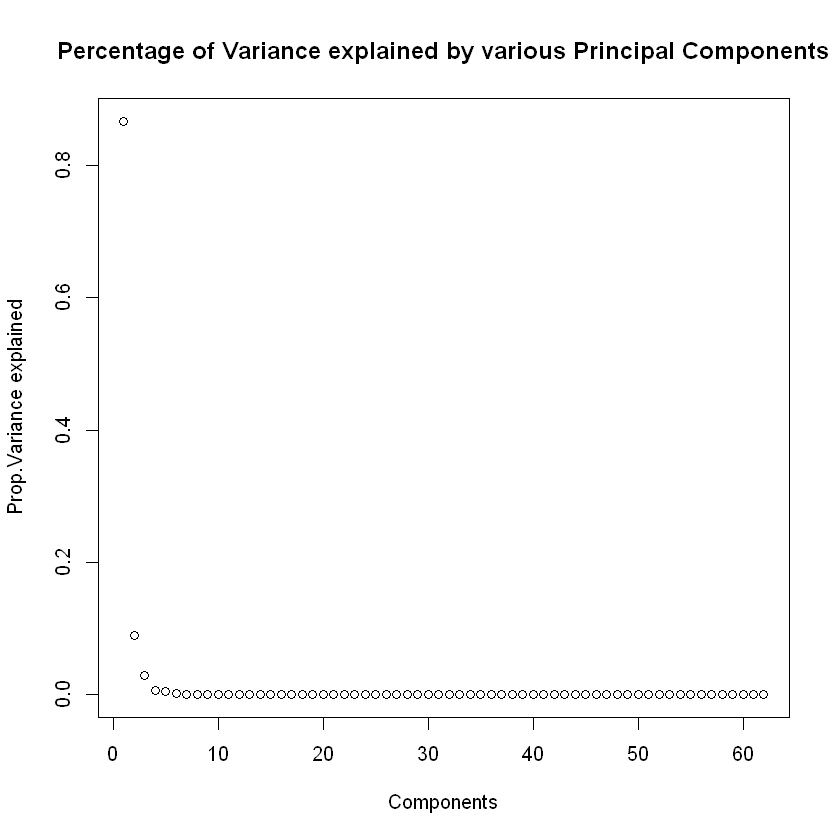

In [8]:
plot(pca$values/length(pca$values), main = "Percentage of Variance explained by various Principal Components", ylab="Prop.Variance explained", xlab = "Components")


# <font color = red>  **Variance Capturability of top 3 Principal Components** </font>

In [9]:
(pca$values[1:3]/sum(pca$values)) * 100

# We can see that the top 3 Principal Components cover almost complete variance (98%-99%) of the data . 
# Variance captured by 1st PCA: 86.72%
# Variance captured by 2nd PCA: 8.98%
# Variance captured by 3rd PCA: 2.86%

[1] 86.718043  8.983166  2.862397

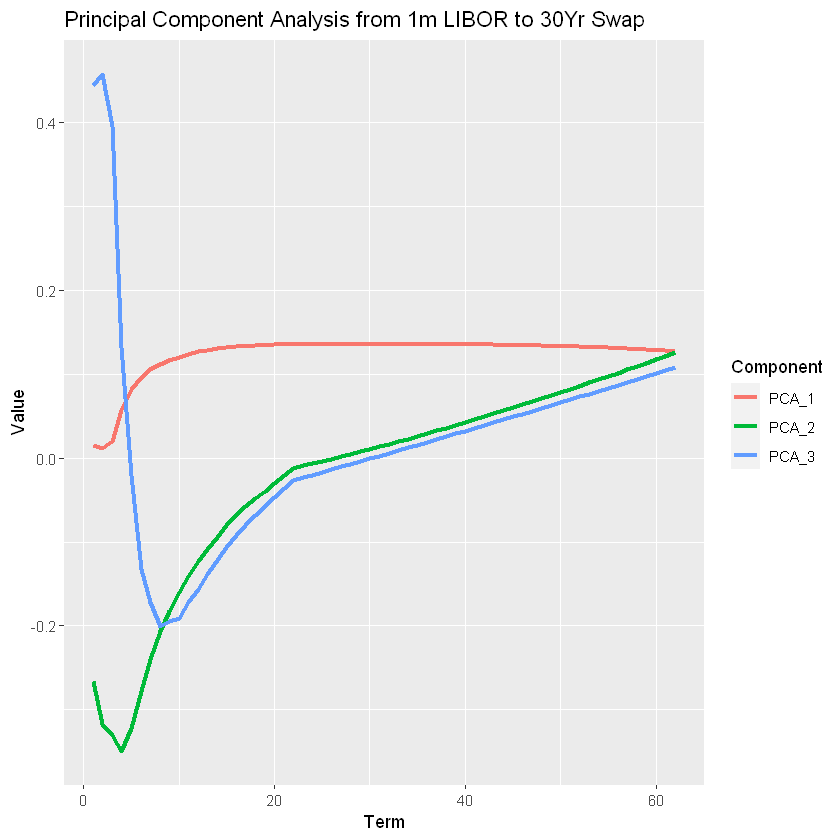

In [10]:
# Plotting top 3 Principal Components from Libor-1m upto Swap-30Yr

pca_long <- data.table(index = 1:62, coredata(pca$vectors[,1:3]))
colnames(pca_long)[2:4] <- c("PCA_1","PCA_2","PCA_3")
melt(pca_long, id="index", variable.name = "Component") -> pca_long

ggplot(pca_long, aes(x=index)) +
  geom_line(aes(y=value, col=Component), size=1.25) +
  labs(title = "Principal Component Analysis from 1m LIBOR to 30Yr Swap", x = "Term", y = "Value")


# <font color = brown> Developing Shocked PCAs and Shocked Interest Rates </font>

In [11]:

# Develop shocks using the principal component vectors and variances
# Need to multiply eigenvectors by eigenvalues. First must get eigevectors in form to multiply easily.

eigenGoodForm <- NULL
stdevRateGoodForm <- NULL
lastRateGoodForm <- NULL
curvePoints <- ncol(scaledSpotPctDiff)
for(i in 1:curvePoints)
{
  eigenGoodForm <- c(eigenGoodForm, c(rep(pca$values[i], curvePoints)))  
  stdevRateGoodForm <- c(stdevRateGoodForm, c(attr(scaledSpotPctDiff, "scaled:scale")))
  lastRateGoodForm <- c(lastRateGoodForm, c((unclass(last(spot))[1,])))
}

# Develop the shocked pc's and the rateShocks

pcaShockUp <- pca$vectors * eigenGoodForm^.5 * qnorm(.995)
rateShockUp <- (1+pcaShockUp*stdevRateGoodForm *sqrt(12))* lastRateGoodForm

pcaShockUp <- subset(data.frame(pcaShockUp), select=-c(4:length(colnames(data.frame(pcaShockUp)))))
colnames(pcaShockUp) <- c("PCA_1_Up", "PCA_2_Up", "PCA_3_Up")
rateShockUp <-  subset(data.frame(rateShockUp), select=-c(4:length(colnames(data.frame(rateShockUp)))))
colnames(rateShockUp) <- c("rate_PCA_1_Up", "rate_PCA_2_Up", "rate_PCA_3_Up")

pcaShockDown <- pca$vectors * eigenGoodForm^.5 * -qnorm(.995)
rateShockDown <- (1+pcaShockDown*stdevRateGoodForm * sqrt(12))* lastRateGoodForm 

pcaShockDown <- subset(data.frame(pcaShockDown), select=-c(4:length(colnames(data.frame(pcaShockDown)))))
colnames(pcaShockDown) <- c("PCA_1_Down", "PCA_2_Down", "PCA_3_Down")
rateShockDown <-  subset(data.frame(rateShockDown), select=-c(4:length(colnames(data.frame(rateShockDown)))))
colnames(rateShockDown) <- c("rate_PCA_1_Down", "rate_PCA_2_Down", "rate_PCA_3_Down")

pcaShock <- cbind(pcaShockUp, pcaShockDown)
pcaShock$Term <- c(1/12, 3/12, seq(from=.5, t=30, by=.5))
col_id <- grep(c("Term"), names(pcaShock))
pcaShock <- pcaShock[,c(col_id, (1:ncol(pcaShock))[-col_id])]

rateShock <- cbind(rateShockUp, rateShockDown)
rateShock$Term <- c(1/12, 3/12, seq(from=.5, t=30, by=.5))
rateShock$Base <- unclass(last(spot))[1,]
col_id <- grep(c("Base"), names(rateShock))
rateShock <- rateShock[,c(col_id, (1:ncol(rateShock))[-col_id])]
col_id <- grep(c("Term"), names(rateShock))
rateShock <- rateShock[,c(col_id, (1:ncol(rateShock))[-col_id])]
rateShock <- as.data.table(rateShock)


Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


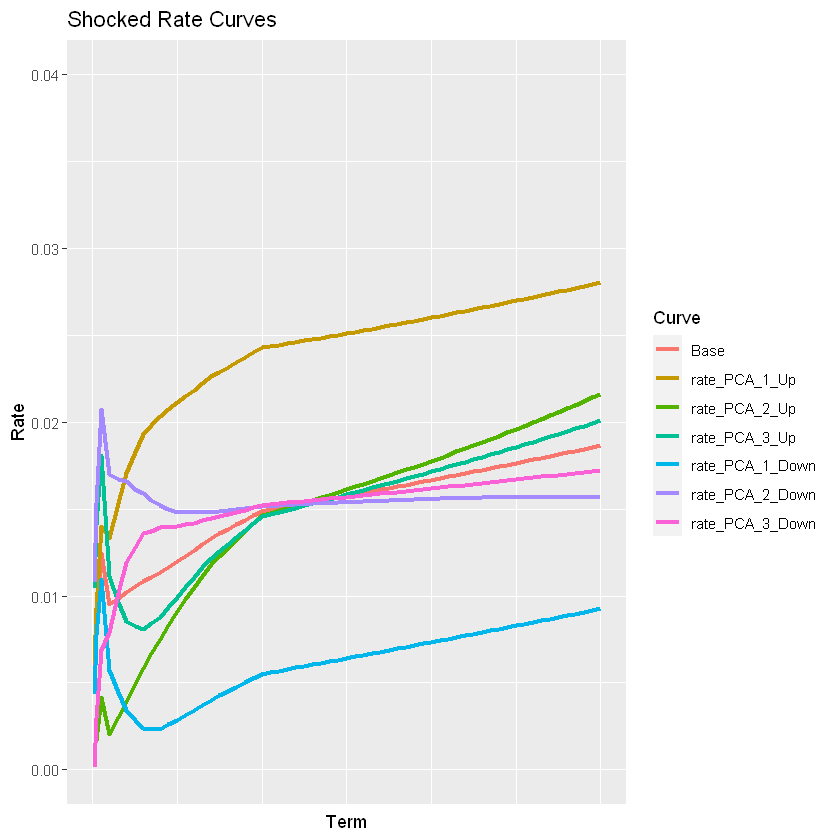

In [12]:
# Converting into Long Format and Plotting the Shocked Rate Curves

rateShock_long <- melt.data.table(rateShock, id = "Term")
colnames(rateShock_long)[2:3] <- c("Curve","Rate")

ggplot(rateShock_long, aes(x=Term)) +
  geom_line(aes(y=Rate, col=Curve), size=1.25) +
  labs(title="Shocked Rate Curves") +
  scale_y_continuous(n.breaks = 4, limits = c(0,0.04)) +
  scale_x_continuous(n.breaks = 3, limits = c(0,30)) +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())


In [13]:

# Saving the required PCA shocks and Interest Rate Shocks files and R WorkSpace.

write.csv(pcaShock, "PCA_Shocks.csv")
write.csv(rateShock, "Rate_Shocks.csv")
save.image("InterestRateModelling_usingPCA.RData")
